# Case-by-case analysis
This notebook demonstrates how to visualize which model managed to solve which test-case how often.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
directory = "../data/"

collection = []
for filename in os.listdir(directory):
    if filename.endswith("_results.jsonl"):
        print(filename)
        df = pd.read_json(directory + filename, lines=True)
        df['model'] = filename.replace(".jsonl_results.jsonl", "").replace("samples_", "")
        collection.append(df)

df = pd.concat(collection)

samples_claude-3-5-sonnet-20240620.jsonl_results.jsonl
samples_claude-3-opus-20240229.jsonl_results.jsonl
samples_codegemma-7b-instruct-fp16.jsonl_results.jsonl
samples_codellama-70b-instruct-q4_0.jsonl_results.jsonl
samples_codellama.jsonl_results.jsonl
samples_command-r-plus-104b-q4_0.jsonl_results.jsonl
samples_deepseek-coder-v2.jsonl_results.jsonl
samples_gemini-1.5-flash-001.jsonl_results.jsonl
samples_gemini-1.5-pro-001.jsonl_results.jsonl
samples_gemini-pro.jsonl_results.jsonl
samples_gpt-3.5-turbo-1106.jsonl_results.jsonl
samples_gpt-4-1106-preview.jsonl_results.jsonl
samples_gpt-4-turbo-2024-04-09.jsonl_results.jsonl
samples_gpt-4o-2024-05-13.jsonl_results.jsonl
samples_gpt-4o-2024-08-06.jsonl_results.jsonl
samples_gpt-4o-mini-2024-07-18.jsonl_results.jsonl
samples_llama3-70b-instruct-q4_0.jsonl_results.jsonl
samples_llama3-70b-instruct-q8_0.jsonl_results.jsonl
samples_llama3-8b-instruct-fp16.jsonl_results.jsonl
samples_mistral-nemo.jsonl_results.jsonl
samples_mixtral-8x22b-in

In [3]:
df.head()

,task_id,completion,full_response,result,passed,model
0,../test_cases/apply_otsu_threshold_and_count_p...,\n# Plan:\n# 1. Import required libraries (cv2...,Here's the completed code with a step-by-step ...,failed: OpenCV(4.9.0) D:\a\opencv-python\openc...,False,claude-3-5-sonnet-20240620
1,../test_cases/binary_closing.ipynb,\n# Plan:\n# 1. Import necessary libraries (nu...,"Here's the completed code with a plan, necessa...",passed,True,claude-3-5-sonnet-20240620
2,../test_cases/binary_skeleton.ipynb,\n# Plan:\n# 1. Import necessary libraries (sk...,Here's the completed code with a step-by-step ...,failed: Input must be a 2D numpy array of bool...,False,claude-3-5-sonnet-20240620
3,../test_cases/bland_altman.ipynb,\n# Plan:\n# 1. Import required libraries (pan...,"Here's the completed code with a plan, necessa...",passed,True,claude-3-5-sonnet-20240620
4,../test_cases/combine_columns_of_tables.ipynb,\n# Plan:\n# 1. Import required library (panda...,Here's the completed code with a step-by-step ...,passed,True,claude-3-5-sonnet-20240620


In [4]:
# Ensure the 'passed' column is boolean for correct processing.
df['passed'] = df['passed'].astype(bool)
# shorten task name
df['task_id'] = [str(t).replace("../test_cases/", "").replace(".ipynb","") for t in df['task_id']]

# Pivot the dataframe to count True 'passed' values for each model-task combination.
pivot_df = df.pivot_table(index='task_id', columns='model', values='passed', aggfunc='mean', fill_value=0)

# Reset the index if 'task_id' needs to be a column instead of an index
pivot_df.reset_index(inplace=True)

# Apply formatting to display only two digits after the decimal point for all columns after the first (task_id column)
pivot_df = pivot_df.round(2)

pivot_df

model,task_id,claude-3-5-sonnet-20240620,claude-3-opus-20240229,codegemma-7b-instruct-fp16,codellama,codellama-70b-instruct-q4_0,command-r-plus-104b-q4_0,deepseek-coder-v2,gemini-1.5-flash-001,gemini-1.5-pro-001,...,gpt-4o-mini-2024-07-18,llama3-70b-instruct-q4_0,llama3-70b-instruct-q8_0,llama3-8b-instruct-fp16,mistral-nemo,mixtral-8x22b-instruct-v0.1-q4_0,mixtral-8x7b-instruct-v0.1-q5_0,o1-mini-2024-09-12,phi3-3.8b-mini-instruct-4k-fp16,reference
0,apply_otsu_threshold_and_count_postiive_pixels,0.0,0.0,0.6,0.0,0.0,0.2,0.0,0.0,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,1.0
1,binary_closing,1.0,1.0,0.2,0.0,0.1,0.1,0.6,0.0,0.9,...,0.9,0.7,0.6,0.3,0.1,0.5,0.3,0.7,0.2,1.0
2,binary_skeleton,0.8,0.6,0.5,0.1,0.1,0.0,0.3,0.0,0.7,...,0.2,0.3,0.2,0.0,0.2,0.0,0.2,1.0,0.0,1.0
3,bland_altman,1.0,1.0,0.8,0.2,0.3,0.1,1.0,1.0,1.0,...,1.0,1.0,1.0,0.6,0.7,0.9,0.5,1.0,0.8,1.0
4,combine_columns_of_tables,1.0,0.1,0.3,0.1,0.2,0.3,1.0,0.3,0.8,...,1.0,1.0,1.0,0.1,0.7,0.9,0.7,1.0,0.5,1.0
5,convex_hull_measure_area,1.0,1.0,0.6,0.2,0.2,0.0,0.2,0.9,1.0,...,1.0,0.1,0.2,0.0,0.0,0.4,0.3,1.0,0.2,1.0
6,convolve_images,0.5,0.7,0.0,0.0,0.1,0.0,0.4,0.1,0.4,...,0.1,0.5,0.4,0.2,0.1,0.1,0.4,0.9,0.2,1.0
7,count_number_of_touching_neighbors,0.8,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3,0.1,0.0,0.0,0.0,0.0,0.0,0.9,0.0,1.0
8,count_objects_over_time,0.6,0.6,0.7,0.1,0.5,0.2,0.6,0.6,0.4,...,0.6,0.5,0.5,0.0,0.3,0.4,0.4,1.0,0.3,1.0
9,count_overlapping_regions,1.0,1.0,0.0,0.0,0.2,0.0,0.2,0.8,0.2,...,0.9,0.6,0.7,0.1,0.1,0.0,0.0,1.0,0.0,1.0


0.13.2


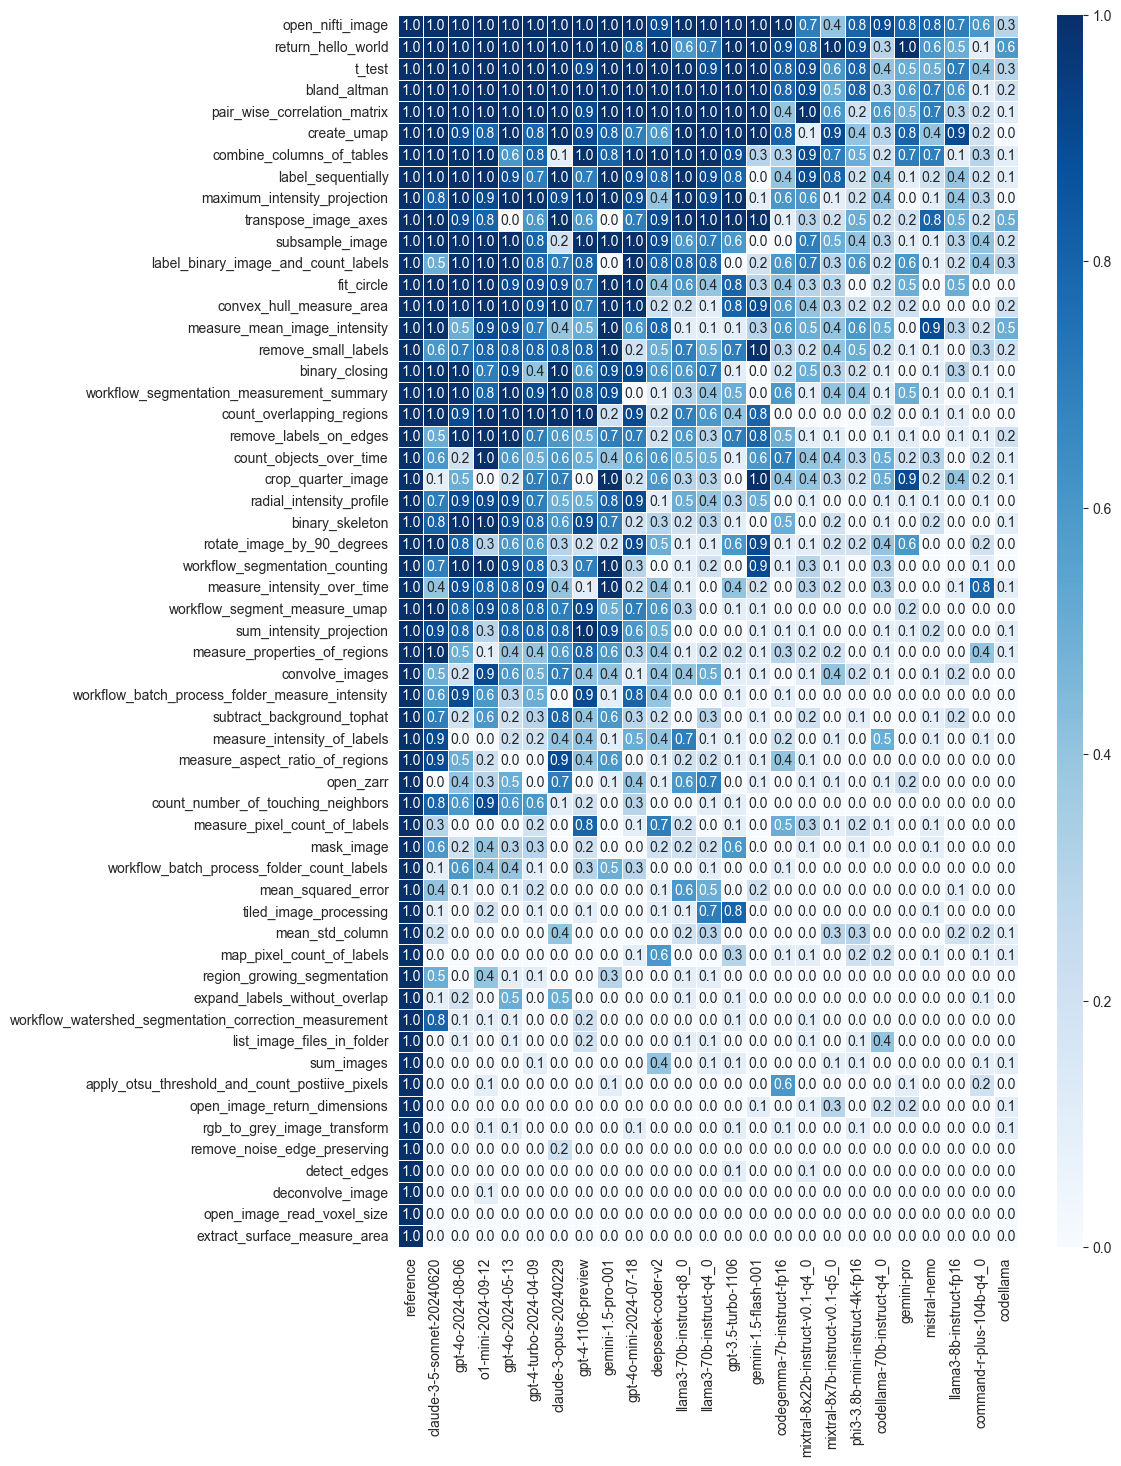

In [5]:
print(sns.__version__)
sns.set_style("white")

df = pivot_df

# Separate the numerical data for plotting and the string column for y-axis labels
numerical_data = df.select_dtypes(include=[np.number])
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
numerical_data = numerical_data[mean_values.index]

df["average_task_score"] = df.iloc[:,1:-1].mean(axis=1)
str_column_values = df.sort_values(by="average_task_score", ascending=False)['task_id']  # Replace 'str_column' with the actual column name

# Plotting
fig = plt.figure(figsize=(10,16))
numerical_data["average_task_score"] = df.iloc[:,1:-1].mean(axis=1)

sns.heatmap(numerical_data.sort_values("average_task_score",ascending=False).drop(columns=("average_task_score")), annot=True, linewidths=.5, yticklabels=str_column_values, fmt=".1f", cbar_kws={'shrink': 1, 'aspect': 3*16}, cmap="Blues")
plt.gca().set_xlabel('')

plt.savefig("../docs/paper/performance_per_task", bbox_inches="tight", dpi=300)
plt.show()

In [6]:
pivot_df.describe()

model,claude-3-5-sonnet-20240620,claude-3-opus-20240229,codegemma-7b-instruct-fp16,codellama,codellama-70b-instruct-q4_0,command-r-plus-104b-q4_0,deepseek-coder-v2,gemini-1.5-flash-001,gemini-1.5-pro-001,gemini-pro,...,llama3-70b-instruct-q4_0,llama3-70b-instruct-q8_0,llama3-8b-instruct-fp16,mistral-nemo,mixtral-8x22b-instruct-v0.1-q4_0,mixtral-8x7b-instruct-v0.1-q5_0,o1-mini-2024-09-12,phi3-3.8b-mini-instruct-4k-fp16,reference,average_task_score
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,...,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.0,57.000000
mean,0.580702,0.470175,0.249123,0.087719,0.177193,0.122807,0.368421,0.294737,0.459649,0.173684,...,0.350877,0.359649,0.142105,0.152632,0.243860,0.207018,0.531579,0.180702,1.0,0.328801
std,0.404633,0.402210,0.293454,0.136369,0.197319,0.166923,0.344424,0.397502,0.430888,0.275504,...,0.354624,0.366382,0.223565,0.246479,0.299415,0.252742,0.423488,0.248164,0.0,0.255772
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,1.0,0.091667
50%,0.700000,0.500000,0.100000,0.000000,0.100000,0.100000,0.400000,0.100000,0.400000,0.000000,...,0.200000,0.200000,0.000000,0.100000,0.100000,0.100000,0.600000,0.100000,1.0,0.341667
75%,1.000000,0.900000,0.500000,0.100000,0.300000,0.200000,0.600000,0.600000,1.000000,0.200000,...,0.700000,0.600000,0.200000,0.100000,0.400000,0.300000,1.000000,0.200000,1.0,0.516667
max,1.000000,1.000000,1.000000,0.600000,0.900000,0.800000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.900000,0.900000,1.000000,1.000000,1.000000,0.900000,1.0,0.870833


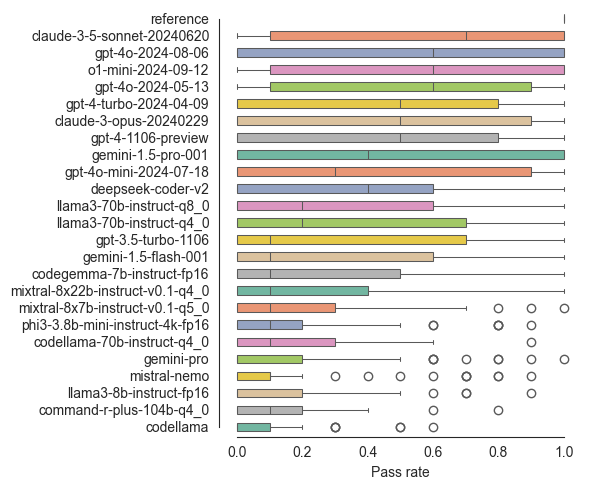

In [7]:
# Assuming pivot_df has 'task_id' as a non-numerical column and the rest are numerical and need to be plotted
numerical_data = pivot_df.drop(columns=['task_id']).drop(columns=("average_task_score"))

# Calculate the mean of each column and sort these means in descending order
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
ordered_numerical_data = numerical_data[mean_values.index]

# Plotting the boxplot with reordered columns and flipping the axes
plt.figure(figsize=(6, 5))
boxplot = sns.boxplot(data=ordered_numerical_data, palette= "Set2", width=0.5, linewidth=0.75, orient='h')
sns.despine(offset=1, trim=True)

plt.yticks(rotation=0)  # Rotate y-axis labels if needed
plt.xlabel('Pass rate')  # Flip label to x-axis
plt.gca().set_ylabel('')  # Remove y-axis label
plt.tight_layout()  # Adjust layout to make room for the y-axis labels

plt.savefig("../docs/paper/pass_rate_llms.png", dpi=700)
plt.show()

In [8]:
with open("model_order.txt", 'w') as f:
    for item in ordered_numerical_data.columns:
        f.write(str(item) + '\n')